In [2]:
import pandas as pd
df = pd.read_csv("ValueCo data extract - ENSAE research project.csv")

In [8]:
print(df.columns)

Index(['isin', 'name', 'sector', 'industry', 'country', 'region', 'score_kind',
       'first_quartile', 'consensus', 'third_quartile', 'strength', 'period'],
      dtype='object')


In [9]:
print(df.head())

           isin                        name       sector  \
0  IE0002424939  Dcc public limited company  Industrials   
1  FR0010451203                    Rexel sa  Industrials   
2  FR0010451203                    Rexel sa  Industrials   
3  FR0000120503                 Bouygues sa  Industrials   
4  CH0002432174        Bucher industries ag  Industrials   

                                  industry      country  region score_kind  \
0      Oil and Gas Retail and Distribution      Ireland  Europe        ESG   
1        Electrical Equipment Distributors       France  Europe          S   
2        Electrical Equipment Distributors       France  Europe          E   
3    Integrated Telecommunication Services       France  Europe          G   
4  Construction Machinery and Heavy Trucks  Switzerland  Europe          E   

   first_quartile  consensus  third_quartile  strength      period  
0            52.4       52.4            52.4     100.0  2020-03-01  
1            60.4       60.4    

Pour obtenir tous les scores d'une entreprise particulière (ici Rexel sa):

In [ ]:
def get_company_data(company_name):
    company_df = df[df['name'] == company_name]  
    return company_df

company = "Rexel sa"  
result = get_company_data(company)

In [ ]:
def detect_score_improvement(df, threshold=10):
    results = []
    df['period'] = pd.to_datetime(df['period'])
    df = df.sort_values(by=['name', 'score_kind', 'period'])
    score_columns = ['first_quartile', 'third_quartile', 'consensus']
    for score_type in df['score_kind'].unique():
        subset = df[df['score_kind'] == score_type].copy() 
        for score_col in score_columns:
            subset[f'{score_col}_diff'] = subset.groupby('name')[score_col].diff()
            improved = subset[subset[f'{score_col}_diff'] >= threshold]
            for _, row in improved.iterrows():
                results.append({
                    'Entreprise': row['name'],
                    'Début': subset[(subset['name'] == row['name']) & 
                                    (subset[score_col] == row[score_col] - row[f'{score_col}_diff'])]['period'].min(),
                    'Fin': row['period'],
                    'Type de Score': score_type,
                    'Mesure': score_col  # Indiquer si l'amélioration est sur Q1, Q3 ou consensus
                })
    return pd.DataFrame(results)

improved_companies = detect_score_improvement(df)
print(improved_companies)

                         Entreprise      Début        Fin Type de Score  \
0                   Adecco group ag 2020-01-01 2021-01-01             E   
1                    Aena sme- s.a. 2024-07-01 2024-10-01             E   
2                          Alfen nv 2022-01-01 2022-12-01             E   
3                    Beijer alma ab 2023-01-01 2023-07-01             E   
4                      Bilfinger se 2023-11-01 2024-07-01             E   
..                              ...        ...        ...           ...   
862                       Thales sa 2023-10-01 2023-11-01             S   
863  Ultra Electronics Holdings plc 2023-01-01 2023-07-01             S   
864                    Veidekke asa 2023-08-01 2023-11-01             S   
865                  Webuild s.p.a. 2023-01-01 2023-07-01             S   
866                Zehnder group ag 2023-07-01 2023-11-01             S   

             Mesure  
0    first_quartile  
1    first_quartile  
2    first_quartile  
3    first_

In [3]:
df['period'] = pd.to_datetime(df['period'])

# Calculer les statistiques par période
stats_by_period = df.groupby('period')['consensus'].describe()

# Afficher le résultat
print(stats_by_period)

             count       mean        std   min     25%   50%     75%   max
period                                                                    
2019-01-01     9.0  56.977778   9.252267  42.5  50.400  58.8  61.100  70.2
2019-02-01    10.0  56.910000   8.725754  42.5  51.875  58.1  60.875  70.2
2019-03-01    10.0  56.910000   8.725754  42.5  51.875  58.1  60.875  70.2
2019-04-01    11.0  56.500000   8.388921  42.5  51.400  57.4  60.650  70.2
2019-05-01    11.0  56.500000   8.388921  42.5  51.400  57.4  60.650  70.2
...            ...        ...        ...   ...     ...   ...     ...   ...
2024-10-01  1743.0  44.260205  23.446009   0.0  34.300  51.8  61.300  89.0
2024-11-01  1743.0  44.260205  23.446076   0.0  34.300  51.8  61.300  89.0
2024-12-01  1743.0  44.260262  23.446059   0.0  34.300  51.8  61.300  89.0
2025-01-01  1743.0  44.259277  23.446662   0.0  34.300  51.8  61.300  89.0
2025-02-01  1743.0  44.259277  23.446662   0.0  34.300  51.8  61.300  89.0

[74 rows x 8 columns]


In [5]:
mean_consensus_per_period = df.groupby('period')['consensus'].mean()

# Calculer la différence d'un mois à l'autre
consensus_variation = mean_consensus_per_period.diff()

# Calculer la moyenne des variations en valeur absolue
mean_absolute_change = consensus_variation.abs().mean()

print(f"📊 Moyenne des variations absolues du consensus : {mean_absolute_change:.2f} points")

📊 Moyenne des variations absolues du consensus : 0.24 points


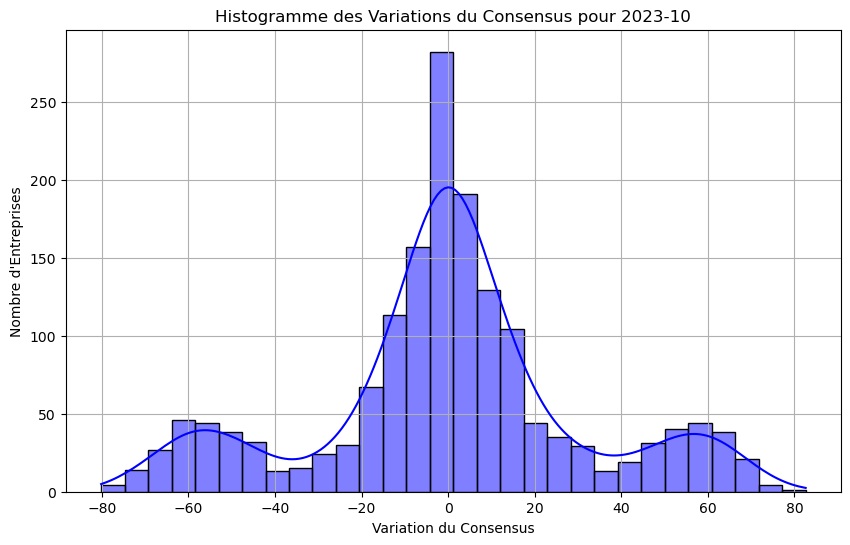

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
df['period'] = pd.to_datetime(df['period'])

# Définir le mois cible
selected_month = "2023-10"  # 📌 Modifier ici pour le mois souhaité

# Filtrer uniquement les périodes du mois sélectionné et du mois précédent
df_filtered = df[df['period'].dt.to_period("M").astype(str).isin([selected_month, (pd.to_datetime(selected_month + "-01") - pd.DateOffset(months=1)).strftime("%Y-%m")])]

# Trier les entreprises par date
df_filtered = df_filtered.sort_values(by=['name', 'period'])

# Calculer la variation du consensus par entreprise
df_filtered['consensus_diff'] = df_filtered.groupby('name')['consensus'].diff()

# Filtrer les variations uniquement pour le mois sélectionné
df_variations = df_filtered[df_filtered['period'].dt.to_period("M").astype(str) == selected_month]

# Tracer l'histogramme des variations du consensus
plt.figure(figsize=(10,6))
sns.histplot(df_variations['consensus_diff'].dropna(), bins=30, kde=True, color="blue")

plt.xlabel("Variation du Consensus")
plt.ylabel("Nombre d'Entreprises")
plt.title(f"Histogramme des Variations du Consensus pour {selected_month}")
plt.grid()
plt.show()